In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets  # Updated to use datasets.ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import os  # Added for path handling in Colab
import timm


In [ ]:
# Define hyperparameters for Diabetic Retinopathy classification using a pretrained ViT
num_classes = 5            # DR severity: Mild, Moderate, Normal, Proliferative, Severe
image_size = 224           #  224x224 images
learning_rate = 1e-4       # Lower learning rate recommended for fine-tuning pretrained models
weight_decay = 0.0001
batch_size = 64  #128           # Adjust based on GPU memory availability
num_epochs = 100


In [8]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # Updated normalization values (ImageNet mean and std)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Define the base directory for your dataset
dataset_dir = "/kaggle/input/drdata/dataset"  # Adjust path as needed in Colab or Kaggle

# Load training, validation, and test sets using ImageFolder
trainset = datasets.ImageFolder(os.path.join(dataset_dir, 'train'), transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

valset = datasets.ImageFolder(os.path.join(dataset_dir, 'validate'), transform=transform)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = datasets.ImageFolder(os.path.join(dataset_dir, 'test'), transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


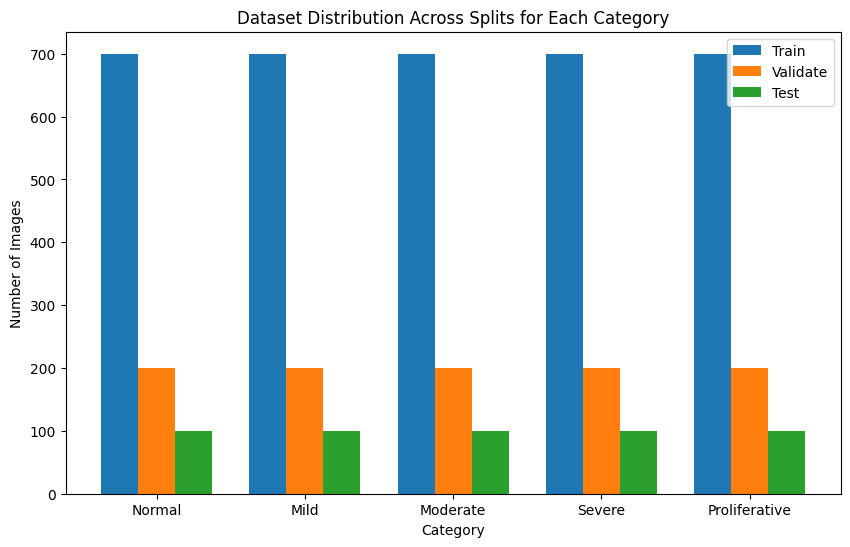

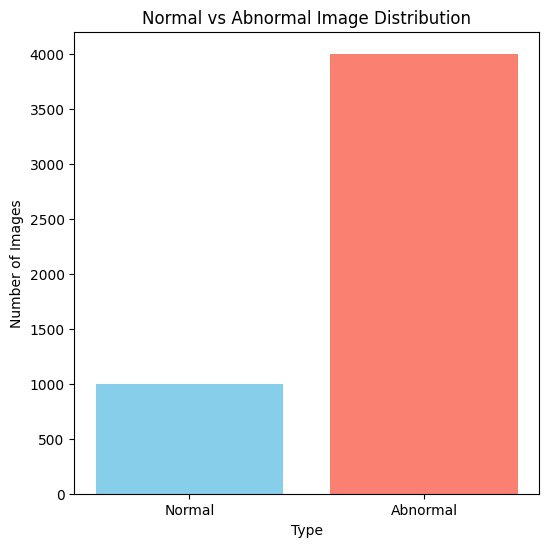

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

########################################
# 1. COLLECT CLASS COUNTS FOR EACH SPLIT
########################################

def get_class_counts(dataset, num_classes=5):
    """Return a list of length num_classes with the count of each label."""
    counts = [0] * num_classes
    for _, label in dataset:
        counts[label] += 1
    return counts

# Get counts from each dataset split
train_counts = get_class_counts(trainset, num_classes=5)
val_counts   = get_class_counts(valset,   num_classes=5)
test_counts  = get_class_counts(testset,  num_classes=5)

# Class names (by index)
categories = ["Normal", "Mild", "Moderate", "Severe", "Proliferative"]

########################################
# 2. PLOT GROUPED BAR CHART
########################################
x = np.arange(len(categories))  # [0, 1, 2, 3, 4]
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each split side by side
rects_train = ax.bar(x - width, train_counts, width, label='Train')
rects_val   = ax.bar(x,         val_counts,   width, label='Validate')
rects_test  = ax.bar(x + width, test_counts,  width, label='Test')

ax.set_xlabel('Category')
ax.set_ylabel('Number of Images')
ax.set_title('Dataset Distribution Across Splits for Each Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

########################################
# 3. PLOT NORMAL VS ABNORMAL
########################################
# Define normal = label 0, abnormal = labels 1..4
# Sum across all splits for a global normal/abnormal distribution
train_normal    = train_counts[0]
train_abnormal  = sum(train_counts[1:])
val_normal      = val_counts[0]
val_abnormal    = sum(val_counts[1:])
test_normal     = test_counts[0]
test_abnormal   = sum(test_counts[1:])

total_normal    = train_normal + val_normal + test_normal
total_abnormal  = train_abnormal + val_abnormal + test_abnormal

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(["Normal", "Abnormal"], [total_normal, total_abnormal],
       color=["skyblue", "salmon"])
ax.set_xlabel("Type")
ax.set_ylabel("Number of Images")
ax.set_title("Normal vs Abnormal Image Distribution")
plt.show()


In [10]:
# Print the class names from the training set
print("Classes in Diabetic Retinopathy Dataset:")
for idx, class_name in enumerate(trainset.classes):
    print(f"{idx}: {class_name}")

# Optionally, also show the mapping from class_name to index
print("\nMapping from class name to index (trainset.class_to_idx):")
for class_name, label_idx in trainset.class_to_idx.items():
    print(f"{class_name} -> {label_idx}")


Classes in Diabetic Retinopathy Dataset:
0: Mild
1: Moderate
2: Normal
3: Proliferative
4: Severe

Mapping from class name to index (trainset.class_to_idx):
Mild -> 0
Moderate -> 1
Normal -> 2
Proliferative -> 3
Severe -> 4


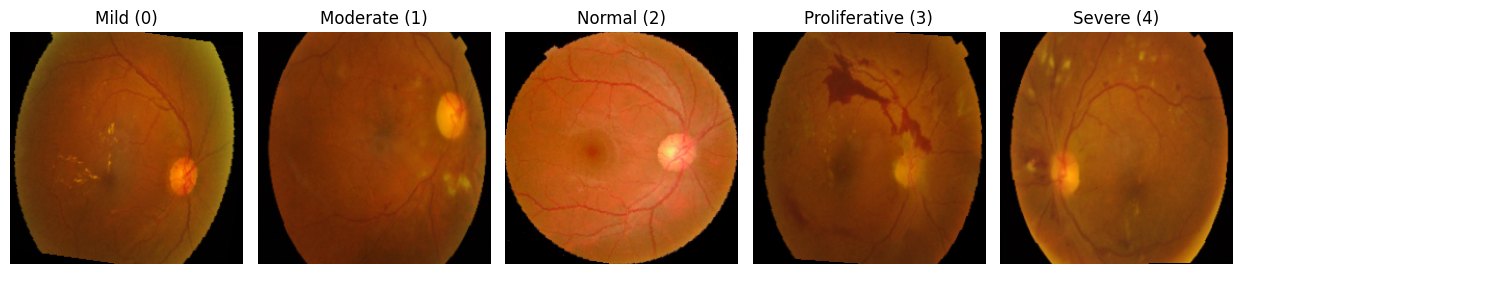

In [11]:
import math
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from collections import defaultdict

# ImageNet normalization parameters (used by the pretrained ViT model)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

def denormalize(img):
    """
    Denormalizes a tensor image using ImageNet mean and std.
    img: a tensor of shape [C, H, W]
    """
    img_denorm = img.clone()
    for t, m, s in zip(img_denorm, imagenet_mean, imagenet_std):
        t.mul_(s).add_(m)
    return img_denorm

# Create a dictionary to store images by class label from the ImageFolder trainset
class_images = defaultdict(list)
for img, label in trainset:
    class_images[label].append(img)

# Determine grid dimensions. Here, we'll show one image per class.
n_classes = len(trainset.classes)  # Should be 5 for Diabetic Retinopathy
ncols = 6  # We'll use 6 columns (adjust if needed)
nrows = math.ceil(n_classes / ncols)

# Create the subplots grid
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
axes = axes.flatten()

# For each class, pick a random image and plot it
for label in range(n_classes):
    if label in class_images:
        random_img = random.choice(class_images[label])
        # Denormalize the image using ImageNet parameters
        random_img = denormalize(random_img)
        axes[label].imshow(random_img.permute(1, 2, 0).cpu().numpy())  # Convert from CxHxW to HxWxC for plotting
        axes[label].set_title(f"{trainset.classes[label]} ({label})")
        axes[label].axis("off")

# Hide any extra subplots (if any)
for i in range(n_classes, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [12]:
# Define MLP
class MLP(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(units[0], units[1]))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


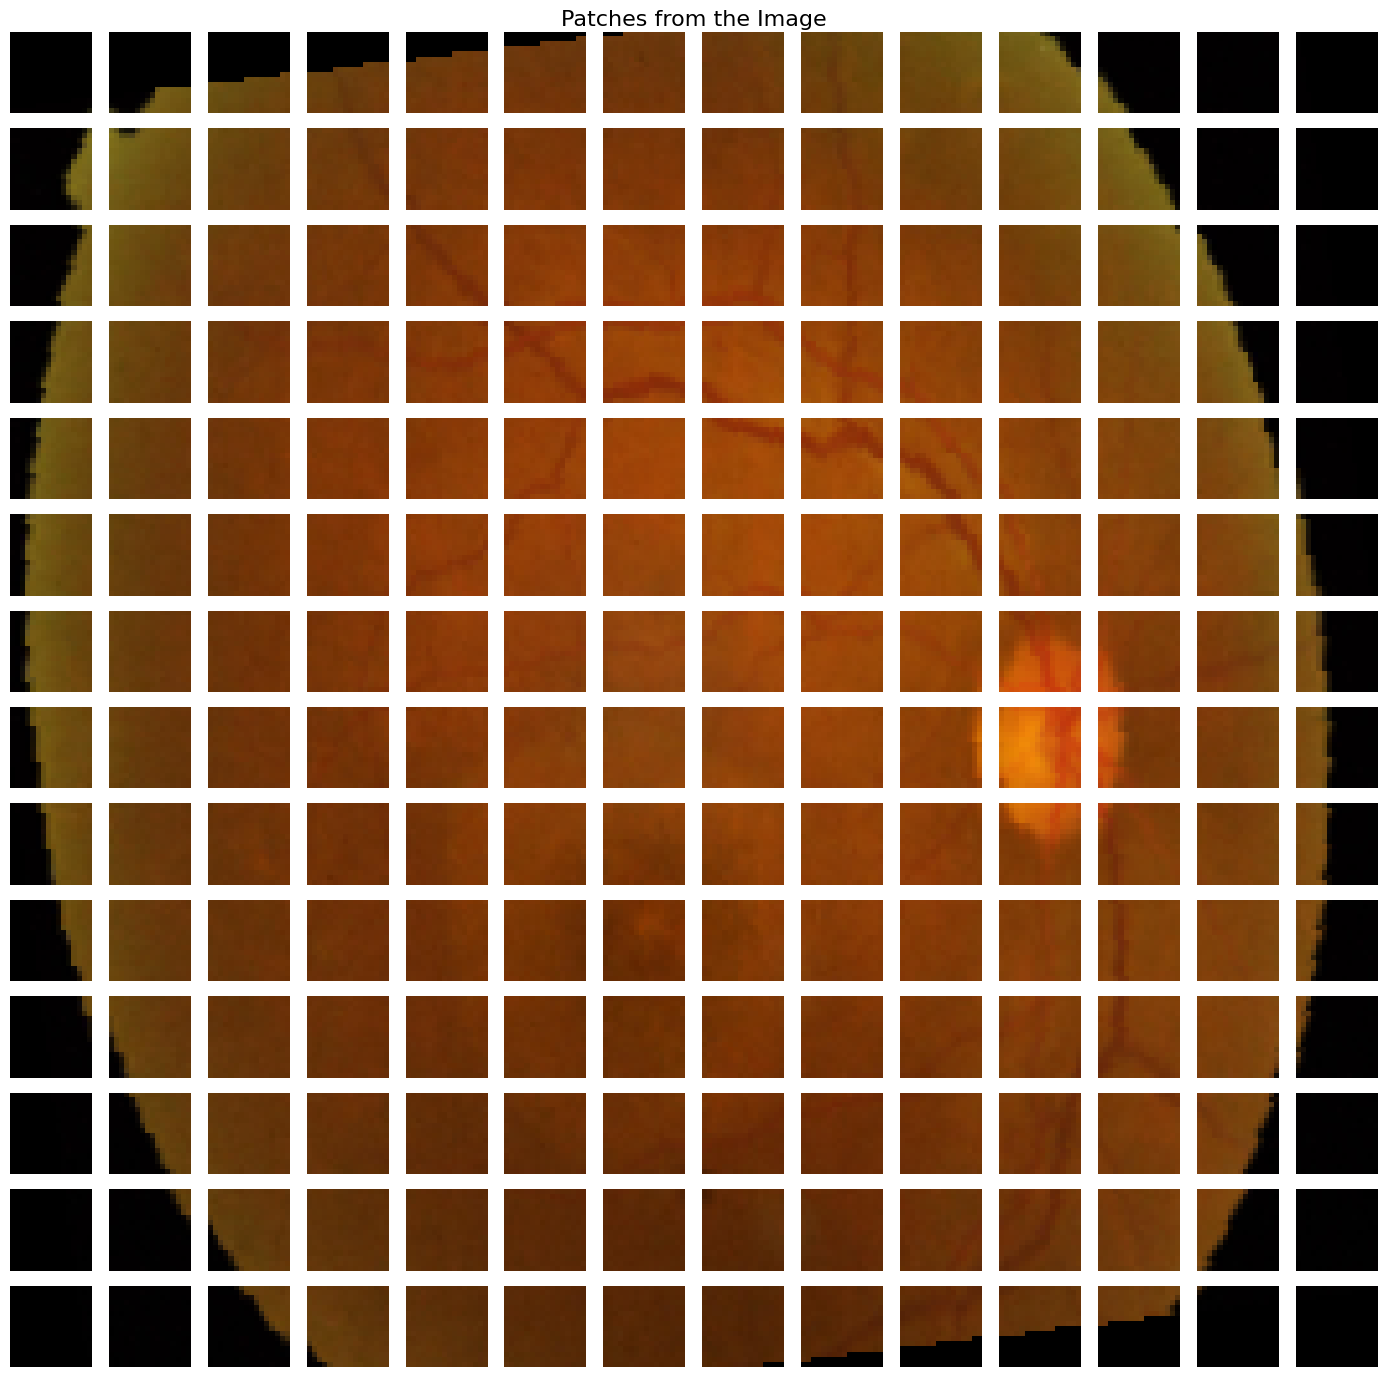

In [13]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Define ImageNet normalization parameters (used for pretrained ViT)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

def denormalize(img, mean, std):
    """Denormalize an image tensor using the provided mean and std."""
    img_denorm = img.clone()
    for t, m, s in zip(img_denorm, mean, std):
        t.mul_(s).add_(m)
    return img_denorm

# Get one sample image and label from the training set
img, label = trainset[0]  # img shape: [3, image_size, image_size] (should be 224x224)
# Denormalize the image using ImageNet parameters
img = denormalize(img, imagenet_mean, imagenet_std)

# Convert tensor to numpy array for plotting (from C x H x W to H x W x C)
img_np = img.permute(1, 2, 0).cpu().numpy()

# Set patch parameters
patch_size = 16  # same as defined in your model
img_size = 224   # updated for Diabetic Retinopathy dataset
n_patches = img_size // patch_size  # should be 14 for 224/16

# Create a grid to display the patches
fig, axes = plt.subplots(n_patches, n_patches, figsize=(14, 14))
axes = axes.flatten()

# Loop over the image and extract patches
for i in range(n_patches):
    for j in range(n_patches):
        # Extract the patch from the image tensor
        patch = img[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
        # Convert patch to numpy for plotting
        patch_np = patch.permute(1, 2, 0).cpu().numpy()
        axes[i * n_patches + j].imshow(patch_np)
        axes[i * n_patches + j].axis("off")

plt.suptitle("Patches from the Image", fontsize=16)
plt.tight_layout()
plt.show()


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

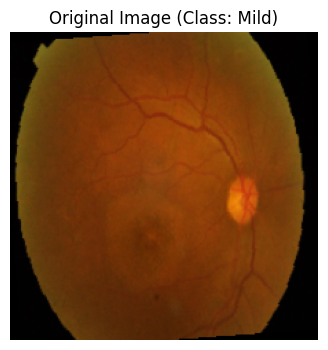

Extracted features shape: torch.Size([1, 197, 768])
First 5 tokens of the feature tensor:
 tensor([[-1.1532,  1.2718, -1.1888,  ..., -0.5977,  1.1243,  0.5487],
        [-0.2868, -1.7267, -0.4174,  ..., -3.8484,  1.4197,  1.2578],
        [-0.1104, -2.1921, -3.1494,  ..., -3.7434,  1.4431,  3.4554],
        [-0.4562, -3.2198, -3.1562,  ..., -3.4411,  1.1047,  2.2376],
        [-1.1231, -3.0575, -1.5376,  ..., -3.9643,  1.1417,  1.3768]],
       grad_fn=<SliceBackward0>)


In [14]:
import torch
import matplotlib.pyplot as plt
import timm
import torchvision.transforms.functional as F

# Instantiate the pretrained ViT model (ViT-B/16) from timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()  # set the model to evaluation mode

# Get one sample image and label from the training set and add a batch dimension
img, label = trainset[0]  # img shape: [3, 224, 224]
img = img.unsqueeze(0)    # new shape: [1, 3, 224, 224]

# Denormalize the image for visualization using ImageNet normalization inverse
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

def denormalize(img_tensor):
    # Assumes img_tensor shape [1, 3, H, W]
    img_denorm = img_tensor.clone()
    for c in range(3):
        img_denorm[:, c, :, :] = img_denorm[:, c, :, :] * imagenet_std[c] + imagenet_mean[c]
    return img_denorm

denorm_img = denormalize(img)
denorm_img_np = denorm_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(denorm_img_np)
plt.title(f"Original Image (Class: {trainset.classes[label]})")
plt.axis("off")
plt.show()

# Extract features from the image using the pretrained ViT model.
# timm's ViT model provides a forward_features() method that returns the features
features = model.forward_features(img)  # shape: [B, num_patches+1, embed_dim]
print("Extracted features shape:", features.shape)

# Print a portion of the feature tensor (first sample, first 5 tokens)
print("First 5 tokens of the feature tensor:\n", features[0, :5, :])


In [ ]:
import timm
import torch.nn as nn

# Define a model using a pretrained Vision Transformer (ViT) for Diabetic Retinopathy
class PretrainedVisionTransformer(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedVisionTransformer, self).__init__()
        # Load a pretrained ViT model (ViT-B/16) from timm
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [16]:
import torch
torch.cuda.empty_cache()


In [18]:
# Make sure to use the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [19]:
model = PretrainedVisionTransformer(num_classes=5).to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
from tqdm import tqdm

best_val_acc = 0
patience = 10  # Number of epochs to wait for improvement before stopping
trigger_times = 0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Create a progress bar for the training loop
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy for the batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        pbar.set_postfix(loss=loss.item())

    # Compute average loss and training accuracy for this epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluate on the validation/test set after each epoch
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in valloader:  # Replace with valloader if available
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    epoch_val_acc = 100 * correct_val / total_val
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Acc: {epoch_val_acc:.2f}%")

    # Early stopping: Check if validation accuracy has improved
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        trigger_times = 0
        # Optionally save the best model state
        best_model_state = model.state_dict()
    else:
        trigger_times += 1
        print(f"No improvement for {trigger_times} epochs.")
        if trigger_times >= patience:
            print("Early stopping triggered. Stopping training.")
            break


Epoch 1/100 Training: 100%|██████████| 55/55 [01:22<00:00,  1.51s/it, loss=1.33]


Epoch 1/100, Loss: 1.6414, Train Acc: 27.74%, Val Acc: 38.80%


Epoch 2/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it, loss=0.816]


Epoch 2/100, Loss: 1.1779, Train Acc: 49.94%, Val Acc: 62.20%


Epoch 3/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it, loss=1.04] 


Epoch 3/100, Loss: 0.9492, Train Acc: 61.57%, Val Acc: 65.00%


Epoch 4/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it, loss=0.566]


Epoch 4/100, Loss: 0.7870, Train Acc: 68.54%, Val Acc: 72.20%


Epoch 5/100 Training: 100%|██████████| 55/55 [01:20<00:00,  1.47s/it, loss=0.593]


Epoch 5/100, Loss: 0.6362, Train Acc: 75.09%, Val Acc: 75.80%


Epoch 6/100 Training: 100%|██████████| 55/55 [01:20<00:00,  1.46s/it, loss=0.501]


Epoch 6/100, Loss: 0.5269, Train Acc: 80.03%, Val Acc: 78.20%


Epoch 7/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.341]


Epoch 7/100, Loss: 0.4452, Train Acc: 83.49%, Val Acc: 75.60%
No improvement for 1 epochs.


Epoch 8/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.367]


Epoch 8/100, Loss: 0.3473, Train Acc: 86.54%, Val Acc: 84.40%


Epoch 9/100 Training: 100%|██████████| 55/55 [01:22<00:00,  1.49s/it, loss=0.246]


Epoch 9/100, Loss: 0.3250, Train Acc: 88.00%, Val Acc: 82.80%
No improvement for 1 epochs.


Epoch 10/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.157]


Epoch 10/100, Loss: 0.2701, Train Acc: 89.80%, Val Acc: 81.40%
No improvement for 2 epochs.


Epoch 11/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.367] 


Epoch 11/100, Loss: 0.2668, Train Acc: 90.00%, Val Acc: 81.80%
No improvement for 3 epochs.


Epoch 12/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.152] 


Epoch 12/100, Loss: 0.1894, Train Acc: 93.43%, Val Acc: 84.60%


Epoch 13/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.169] 


Epoch 13/100, Loss: 0.1617, Train Acc: 94.20%, Val Acc: 83.80%
No improvement for 1 epochs.


Epoch 14/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.104] 


Epoch 14/100, Loss: 0.1650, Train Acc: 94.17%, Val Acc: 83.60%
No improvement for 2 epochs.


Epoch 15/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.123] 


Epoch 15/100, Loss: 0.1463, Train Acc: 95.09%, Val Acc: 84.20%
No improvement for 3 epochs.


Epoch 16/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.105] 


Epoch 16/100, Loss: 0.1133, Train Acc: 96.31%, Val Acc: 87.00%


Epoch 17/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.195]  


Epoch 17/100, Loss: 0.1322, Train Acc: 95.06%, Val Acc: 89.00%


Epoch 18/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.0247]


Epoch 18/100, Loss: 0.0887, Train Acc: 96.97%, Val Acc: 86.00%
No improvement for 1 epochs.


Epoch 19/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.286] 


Epoch 19/100, Loss: 0.1018, Train Acc: 96.69%, Val Acc: 86.60%
No improvement for 2 epochs.


Epoch 20/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.132] 


Epoch 20/100, Loss: 0.1249, Train Acc: 95.43%, Val Acc: 86.40%
No improvement for 3 epochs.


Epoch 21/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.47s/it, loss=0.143] 


Epoch 21/100, Loss: 0.1069, Train Acc: 95.91%, Val Acc: 84.80%
No improvement for 4 epochs.


Epoch 22/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.0683]


Epoch 22/100, Loss: 0.1045, Train Acc: 96.37%, Val Acc: 85.00%
No improvement for 5 epochs.


Epoch 23/100 Training: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it, loss=0.0746]


Epoch 23/100, Loss: 0.0896, Train Acc: 96.74%, Val Acc: 83.00%
No improvement for 6 epochs.


Epoch 24/100 Training: 100%|██████████| 55/55 [01:22<00:00,  1.49s/it, loss=0.119] 


Epoch 24/100, Loss: 0.1039, Train Acc: 96.54%, Val Acc: 87.60%
No improvement for 7 epochs.


Epoch 25/100 Training: 100%|██████████| 55/55 [01:22<00:00,  1.50s/it, loss=0.351] 


Epoch 25/100, Loss: 0.0880, Train Acc: 96.83%, Val Acc: 84.40%
No improvement for 8 epochs.


Epoch 26/100 Training: 100%|██████████| 55/55 [01:22<00:00,  1.50s/it, loss=0.153] 


Epoch 26/100, Loss: 0.0976, Train Acc: 96.34%, Val Acc: 86.60%
No improvement for 9 epochs.


Epoch 27/100 Training: 100%|██████████| 55/55 [01:22<00:00,  1.49s/it, loss=0.0482]


Epoch 27/100, Loss: 0.0980, Train Acc: 96.43%, Val Acc: 88.20%
No improvement for 10 epochs.
Early stopping triggered. Stopping training.


In [23]:
model.eval()
correct_val = 0
total_val = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

final_val_acc = 100 * correct_val / total_val
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


Final Validation Accuracy: 88.40%


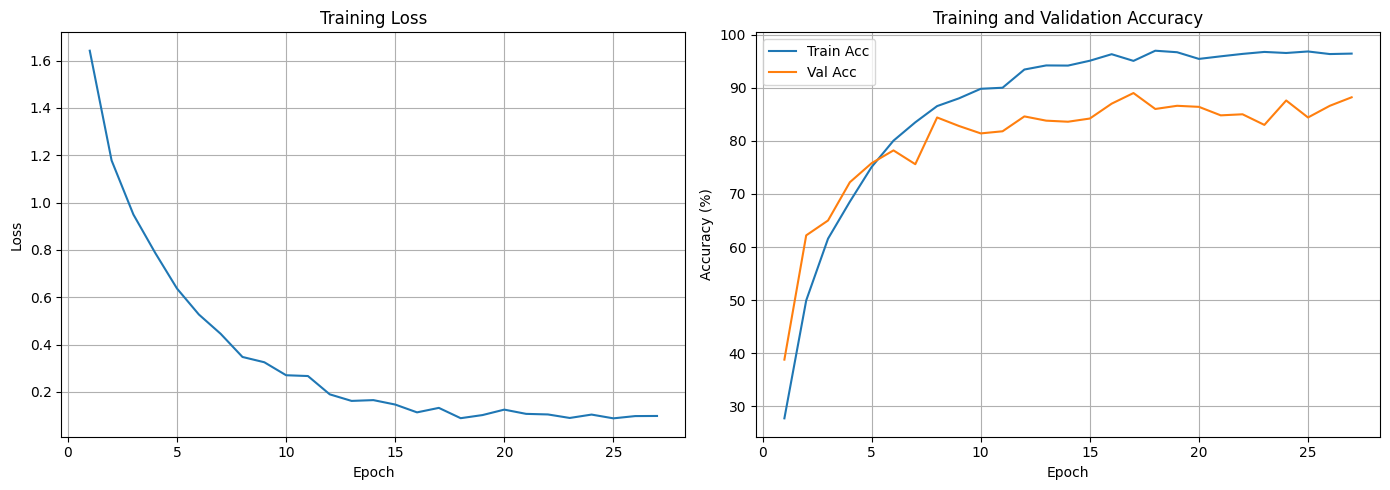

In [27]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Plot training loss with grid
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot training and validation accuracy with grid
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Suppose 'best_model_state' is the state_dict of the best model
# (e.g., highest validation accuracy).
# If you want to save the final model, you can just use model.state_dict().

best_model_state = model.state_dict()
torch.save(best_model_state, "best_model.pth")
print("Model saved to best_model.pth")


Model saved to best_model.pth


In [30]:
import torch

# 1. Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new instance of your model (with the same architecture)
model_test = PretrainedVisionTransformer(num_classes=5)
model_test.load_state_dict(torch.load("best_model.pth", map_location=device, weights_only=True))
model_test.to(device)
model_test.eval()

# 2. Evaluate on the Test Set
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_test(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

final_test_acc = 100.0 * correct_test / total_test
print(f"Test Accuracy: {final_test_acc:.2f}%")


Test Accuracy: 89.80%
